In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import geometry
import shapely.speedups
from tqdm import tqdm
from syspy.skims import skims
from sklearn.cluster import KMeans
from quetzal.model import stepmodel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of input data
## Generates a DataFrame of PT stops with mean weighted distances to population cells
## Needs all PT nodes

In [2]:
input_path = '../input_static/spatial_'
output_path = '../output/'
model_path = '../input_static/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_network')

In [4]:
# Map nodes to zones
if 'FID' not in sm.nodes.columns:
    shapely.speedups.enable()
    sm.nodes['FID'] = np.nan
    sm.nodes = gpd.GeoDataFrame(sm.nodes, crs=sm.epsg)
    for _, zone in tqdm(sm.zones.iterrows(), total=sm.zones.shape[0]):
        sm.nodes.loc[sm.nodes['geometry'].within(zone['geometry']), 'FID'] = zone['NUTS_ID']
    #sm.nodes.to_file(model_path + 'de_pt_network/nodes.geojson', driver='GeoJSON', encoding='utf-8')

100%|████████████████████████████████████████████████████████████████████████████████| 401/401 [00:40<00:00,  9.81it/s]


In [5]:
bus = stepmodel.read_json(model_path + 'de_pt_network_bus')

In [6]:
# Map bus nodes to zones
if 'FID' not in bus.nodes.columns:
    shapely.speedups.enable()
    bus.nodes['FID'] = np.nan
    bus.nodes = gpd.GeoDataFrame(bus.nodes, crs=sm.epsg)
    for _, zone in tqdm(bus.zones.iterrows(), total=bus.zones.shape[0]):
        bus.nodes.loc[bus.nodes['geometry'].within(zone['geometry']), 'FID'] = zone['NUTS_ID']
    #bus.nodes.to_file(model_path + 'de_pt_network_bus/nodes.geojson', driver='GeoJSON', encoding='utf-8')

100%|████████████████████████████████████████████████████████████████████████████████| 401/401 [16:00<00:00,  2.40s/it]


In [7]:
# Merge
sm.nodes = sm.nodes.append(bus.nodes)

## Use census data
The important question for mode choice problems: How long/inconvenient is it from home to the next PT stop? </br>
Approach: Build population densities from census data and calculate the mean weighted distance to the next PT stop.

In [8]:
# Load census data: Zensus 2011 - Einwohnerzahl je Hektar
# Copyright: © Statistisches Bundesamt, Wiesbaden 2015
# (im Auftrag der Herausgebergemeinschaft)
# Vervielfältigung und Verbreitung, auch auszugsweise, mit Quellenangabe gestattet
if os.path.isfile(input_path + 'Zensus_2011.geojson'):
    pop = gpd.read_file(input_path + 'Zensus_2011.geojson', driver='GeoJSON')
else:
    pop = pd.read_csv(input_path + 'Zensus_2011.csv', sep=';')
    # Restrict to entries that hold information
    pop = pop.loc[pop['Einwohner']!=-1]
    pop = gpd.GeoDataFrame(pop[['Einwohner']],
                          geometry=gpd.points_from_xy(pop['x_mp_100m'], pop['y_mp_100m']))
    pop.crs = 3035
    pop.to_crs(sm.epsg, inplace=True)

In [9]:
print(pop.shape)
pop.head(2)

(3177723, 4)


,Einwohner,NUTS_ID,FID,geometry
0,8,DE27E,DE27E,POINT (10.21212 47.31574)
1,7,DE27E,DE27E,POINT (10.26631 47.31562)


In [10]:
pop_r = pop

In [11]:
# Restrict to a geometric hull
#sm.zones = gpd.GeoDataFrame(sm.zones)
#hull = sm.zones["geometry"].buffer(1e-3).unary_union
# Restrict to the geometric hull if the latter is not Germany
#pop_r = pop.loc[pop['geometry'].apply(lambda p: p.within(hull))]
#print(pop_r.shape)

In [12]:
# Map to zones
if 'NUTS_ID' not in pop_r.columns:
    shapely.speedups.enable()
    zones = gpd.GeoDataFrame(sm.zones.sort_values('area', ascending=False), crs=sm.epsg)
    #centr['geometry'] = zones['geometry'].centroid
    pop_r['NUTS_ID'] = np.nan
    for _, zone in tqdm(zones.iterrows(), total=sm.zones.shape[0]):
        geo = zone['geometry'].buffer(0.08)
        pop_r.loc[pop_r['geometry'].within(geo), 'NUTS_ID'] = zone['NUTS_ID']
    pop_r.to_file(input_path + 'Zensus_2011.geojson', driver='GeoJSON')

In [15]:
pop_r.loc[pop_r['NUTS_ID'].isna()]

,Einwohner,NUTS_ID,FID,geometry
3816,5,None,DE27A,POINT (9.91838 47.53103)
3962,13,None,DE27A,POINT (9.73521 47.53524)
3994,13,None,DE27A,POINT (9.73654 47.53615)
5554,19,None,DE27A,POINT (9.74703 47.56137)
7497,5,None,DE13A,POINT (8.08700 47.55841)
...,...,...,...,...
3177060,3,None,DEF07_1,POINT (8.69160 54.90699)
3177077,3,None,DEF07_1,POINT (8.69001 54.90787)
3177148,9,None,DEF07_1,POINT (8.67119 54.91127)
3177149,3,None,DEF07_1,POINT (8.67275 54.91129)


<AxesSubplot:>

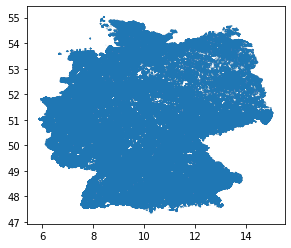

In [16]:
# Visualise
#zones_plot = sm.plot('zones', alpha=0.1, figsize=[16, 9], color='green')
pop_r.plot(markersize=list(pop_r['Einwohner']/300), alpha=0.2)#, ax=zones_plot)

### Apply K-Means to find weighted distances of PT stops

In [17]:
sm.nodes.shape

(429186, 4)

In [18]:
# Settings:
dist_col = 'weighted_dist'
mean_dist_col = 'mean_weighted_dist'
cent_col = 'cluster_center'
pop_col = 'population'
max_iter_per_group = 10

In [22]:
tqdm.pandas()
errors = []
def weighted_dist(zone):
    nuts_id = zone['FID'].unique()[0]
    # Get the population points
    pop_p = pop_r.loc[pop_r['NUTS_ID']==nuts_id]
    # Count the number of PT stops in the zone and make it the number of clusters
    n_clusters = len(zone.index)
    if n_clusters > 0:
        # Prepare sample
        X = np.array([[p.x, p.y] for p in list(pop_p['geometry'])])
        # Prepare initial starting points
        nodes_coords = np.array([[p.x, p.y] for p in list(zone['geometry'])])
        # Apply weighted K-Means
        kmeans = KMeans(n_clusters=n_clusters,
                        random_state=0,
                        init=nodes_coords,
                        max_iter=max_iter_per_group)
        try:
            kmeans.fit(X, sample_weight=np.array(list(pop_p['Einwohner'])))
        except ValueError: # More stations than samples
            zone[cent_col] = zone['geometry']
            zone[pop_col] = pop_p['Einwohner'].sum() / n_clusters
            zone[dist_col] = 100
            zone[mean_dist_col] = 100
            return zone
        # Create results DataFrame
        zone[cent_col] = [geometry.Point(c[0], c[1]) for c in kmeans.cluster_centers_]
        # Add population to calculate the mean weighted distance for each zone later
        pop_p['cluster'] = list(kmeans.labels_)
        #    kmeans.predict(X, sample_weight=np.array(list(pop_p['Einwohner']))))
        try:
            zone[pop_col] = list(pop_p.groupby('cluster').agg({'Einwohner': 'sum'})['Einwohner'])
        except ValueError: # Fewer labels than n_clusters
            zone[pop_col] = pop_p['Einwohner'].mean()
            errors.append((nuts_id, zone['route_type'].unique()[0]))
        # Calculate distance between centroid and PT node
        zone[dist_col] = [skims.get_distance_from_lon_lat_in_m(kmeans.cluster_centers_[i][0],
                                                               kmeans.cluster_centers_[i][1],
                                                               nodes_coords[i][0],
                                                               nodes_coords[i][1])
                          for i in range(n_clusters)]
        # Add mean weighted distance
        zone[mean_dist_col] = (zone[pop_col]*zone[dist_col]).sum() / zone[pop_col].sum()
        return zone
    else:
        return

In [ ]:
# Generate clusters for every route type
clusters = sm.nodes.groupby(['route_type', 'FID']).progress_apply(weighted_dist)

In [24]:
errors

[('DE111', 'bus'),
 ('DE112', 'bus'),
 ('DE113', 'bus'),
 ('DE114', 'bus'),
 ('DE115', 'bus'),
 ('DE116', 'bus'),
 ('DE117', 'bus'),
 ('DE118', 'bus'),
 ('DE119', 'bus'),
 ('DE11A', 'bus'),
 ('DE11B', 'bus'),
 ('DE11C', 'bus'),
 ('DE11D', 'bus'),
 ('DE121', 'bus'),
 ('DE123', 'bus'),
 ('DE124', 'bus'),
 ('DE125', 'bus'),
 ('DE126', 'bus'),
 ('DE127', 'bus'),
 ('DE128', 'bus'),
 ('DE129', 'bus'),
 ('DE12A', 'bus'),
 ('DE12B', 'bus'),
 ('DE12C', 'bus'),
 ('DE131', 'bus'),
 ('DE132', 'bus'),
 ('DE133', 'bus'),
 ('DE135', 'bus'),
 ('DE139', 'bus'),
 ('DE13A', 'bus'),
 ('DE141', 'bus'),
 ('DE142', 'bus'),
 ('DE143', 'bus'),
 ('DE144', 'bus'),
 ('DE145', 'bus'),
 ('DE146', 'bus'),
 ('DE147', 'bus'),
 ('DE148', 'bus'),
 ('DE149', 'bus'),
 ('DE211', 'bus'),
 ('DE212', 'bus'),
 ('DE215', 'bus'),
 ('DE216', 'bus'),
 ('DE217', 'bus'),
 ('DE218', 'bus'),
 ('DE219', 'bus'),
 ('DE21A', 'bus'),
 ('DE21B', 'bus'),
 ('DE21C', 'bus'),
 ('DE21D', 'bus'),
 ('DE21F', 'bus'),
 ('DE21H', 'bus'),
 ('DE21K', '

In [25]:
clusters.sample(4)

,FID,geometry,route_type,stop_name,cluster_center,population,weighted_dist,mean_weighted_dist
index,,,,,,,,
bus_n_324443,DEB22,POINT (7.08599 49.77096),bus,"Morscheid, Grundschule",POINT (7.088409112763964 49.7718740384315),168.000000,201.261278,905.055311
bus_n_249464,DE942,POINT (7.25603 53.37902),bus,"Emden, Osterhörn, Mast 2",POINT (7.25642501516962 53.37818787316021),29.190643,96.220955,1356.760214
bus_n_156546,DEC01,POINT (7.04120 49.27720),bus,Dudweiler Krankenhaus,POINT (7.040577313210172 49.27649209614879),33.810691,90.901756,2328.064171
bus_n_367342,DE717,POINT (8.38519 49.99291),bus,Rüsselsheim Teilebau NRüsselsh.Zen,POINT (8.555757186570428 49.97548185405405),44.432413,12348.120671,7249.452463


route_type
air                    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
bus                    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
coach                  [[AxesSubplot(0.125,0.125;0.775x0.755)]]
rail_long_distance     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
rail_short_distance    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

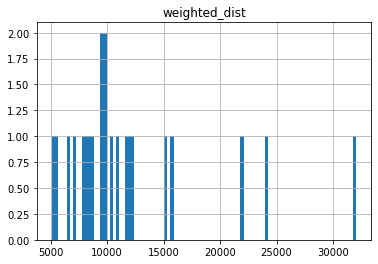

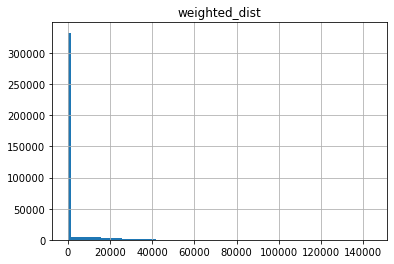

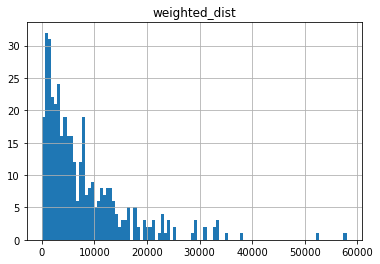

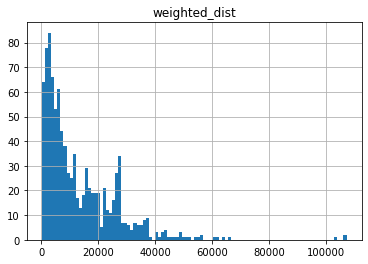

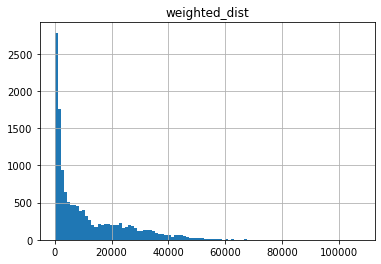

In [26]:
clusters.groupby('route_type').hist(column=dist_col, bins=100)

route_type
air                    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
bus                    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
coach                  [[AxesSubplot(0.125,0.125;0.775x0.755)]]
rail_long_distance     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
rail_short_distance    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

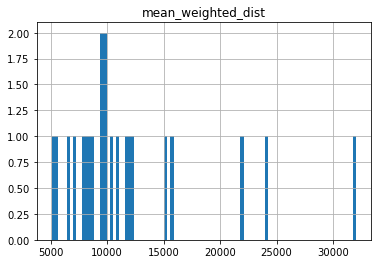

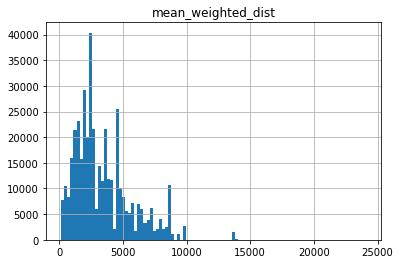

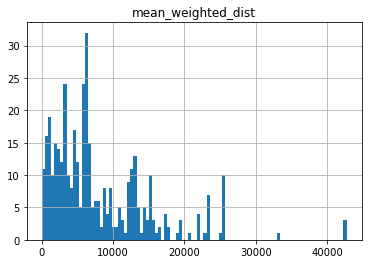

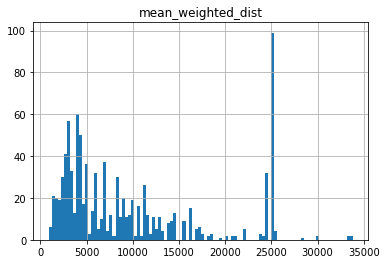

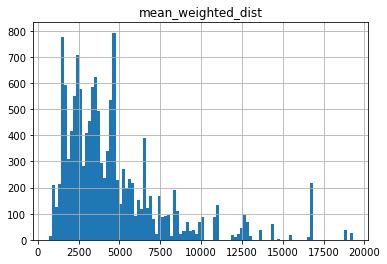

In [27]:
clusters.groupby('route_type').hist(column=mean_dist_col, bins=100)

In [28]:
# Save the population centroids
clusters.to_csv('../input/spatial_census_refined.csv')